In [198]:
from __future__ import print_function

In [199]:
import sys
sys.path.append('../')
sys.path.append('../../build/')

In [200]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [201]:
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator

In [202]:
import versor as vsr
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver

# Ground truth motor

In [203]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor_circle = vsr.Vec(0.05,0.05,0.05).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)
noise_motor_lines = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
noise_motor_points = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(0,0,1) * (np.pi/100))

# Dataset

In [204]:
sph = vsr.Sph(vsr.Vec(1,-1,1).null(), 0.3)
pnt = sph.pnt()
dlp = vsr.Dlp(vsr.Vec(1,1,1).unit(), 1)
cir = vsr.Cir(vsr.Vec(1,0.5,1).null(), 0.5, vsr.Vec(1,2,3).unit().unduale())
p1 = vsr.Vec(1,0,1).null()
p2 = vsr.Vec(3,2,1).null()
dll = vsr.Dll(p1,p2).unit()

In [205]:
points_a = [pnt]
lines_a = [dll]
planes_a = [cir.pln().dual()]
circs_a = [cir.pnt()]

points_b = [p.spin(motor) for p in points_a]
lines_b = [d.spin(motor) for d in lines_a]
planes_b = [d.spin(motor) for d in planes_a]
circs_b = [c.spin(motor) for c in circs_a]

points_b_noisy = [p.spin(noise_motor_points) for p in points_b]
lines_b_noisy = [d.spin(noise_motor_lines) for d in lines_b]
planes_b_noisy = [d.spin(noise_motor_circle) for d in planes_b]
circs_b_noisy = [c.spin(noise_motor_circle) for c in circs_b]

In [207]:
scene = Scene(children=[
        frame_mesh(),
        
        sphere_mesh(sph,color=Colors.HOTPINK),
        line_mesh(dll, color=Colors.HOTPINK),
        circle_mesh(cir, color=Colors.HOTPINK),

        sphere_mesh(sph.spin(motor),color=Colors.LIGHTSKYBLUE),
        line_mesh(dll.spin(motor), length=100, color=Colors.LIGHTSKYBLUE),
        circle_mesh(cir.spin(motor), color=Colors.LIGHTSKYBLUE),
        
        sphere_mesh(sph.spin(motor).spin(noise_motor_points),color='palegreen'),
        line_mesh(dll.spin(motor).spin(noise_motor_lines), color='palegreen'),
        circle_mesh(cir.spin(motor).spin(noise_motor_circle), color='palegreen'),
        AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
renderer.width = '1024'
renderer.height = '768'
display(renderer)

# Estimate motor
## Noise

In [183]:
initial_motors = [vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
                  vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(0,1,0) * (np.pi/6.0 + np.pi/2.))]

summaries_noise = []
estimated_motors_noise = []
for initial_motor in initial_motors:
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(planes_a, planes_b_noisy):
        mes.add_dual_plane_angle_error_residual_block(a,b)
    for a, b in zip(lines_a, lines_b_noisy):
        mes.add_line_correspondences_residual_block(a,b)
    for a, b in zip(points_a, points_b_noisy):
        mes.add_point_correspondences_residual_block(a,b)
    for a, b in zip(circs_a, circs_b_noisy):
        mes.add_point_correspondences_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = "DENSE_QR"
#     mes.max_num_iterations = 100
    em, summary_het, _ = mes.solve()
    estimated_motors_noise.append(em)
    summaries_noise.append(summary_het)
    print(motor)
    print(em)
    print(summary_het['brief_report'])
    print()
    
summaries_no_noise = []
estimated_motors_no_noise = []
for initial_motor in initial_motors:
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(planes_a, planes_b):
        mes.add_dual_plane_angle_error_residual_block(a,b)
    for a, b in zip(lines_a, lines_b):
        mes.add_line_correspondences_residual_block(a,b)
    for a, b in zip(points_a, points_b):
        mes.add_point_correspondences_residual_block(a,b)
    for a, b in zip(circs_a, circs_b):
        mes.add_point_correspondences_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = "DENSE_QR"
    em, summary_het, _ = mes.solve()
    estimated_motors_no_noise.append(em)
    summaries_no_noise.append(summary_het)
    print(motor)
    print(em)
    print(summary_het['brief_report'])
    print()

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ 0.87 -0.013 -0.5 -0.014 -0.71 -0.46 -0.2 -0.25 ]
Ceres Solver Report: Iterations: 4, Initial cost: 5.208743e+00, Final cost: 1.374748e-02, Termination: CONVERGENCE

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ -0.87 0.013 0.5 0.014 0.71 0.46 0.2 0.25 ]
Ceres Solver Report: Iterations: 9, Initial cost: 3.317328e+01, Final cost: 1.374747e-02, Termination: CONVERGENCE

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ 0.87 -3.8e-14 -0.5 1.9e-14 -0.68 -0.43 -0.18 -0.25 ]
Ceres Solver Report: Iterations: 5, Initial cost: 4.890079e+00, Final cost: 7.448793e-26, Termination: CONVERGENCE

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ -0.87 -6.6e-10 0.5 -1.4e-09 0.68 0.43 0.18 0.25 ]
Ceres Solver Report: Iterations: 9, Initial cost: 3.098674e+01, Final cost: 1.387010e-17, Termination: CONVERGENCE



In [185]:
vd = VDMotorEstimationSolver()
vd.add_point_observations(points_a, points_b_noisy)
vd.add_point_observations(circs_a, circs_b_noisy)
vd.add_dual_line_observations(lines_a, lines_b_noisy)
vd.add_dual_plane_observations(planes_a, planes_b_noisy)
vd_estimated_motor_noise = vd.solve()
print(vd_estimated_motor_noise)

vd = VDMotorEstimationSolver()
vd.add_point_observations(points_a, points_b)
vd.add_dual_line_observations(lines_a, lines_b)
vd.add_dual_plane_observations(planes_a, planes_b)
vd_estimated_motor = vd.solve()
print(vd_estimated_motor)

Mot: [ 0.88 -0.031 -0.48 -0.0095 -0.68 -0.44 -0.23 -0.22 ]
Mot: [ 0.87 2.7e-16 -0.5 8.7e-17 -0.68 -0.43 -0.18 -0.25 ]


In [223]:
scene = Scene(children=[
        frame_mesh(),
#         point_mesh(pnt,color=Colors.HOTPINK),
#         line_mesh(dll, color=Colors.HOTPINK),
#         circle_mesh(cir, color=Colors.HOTPINK),

        point_mesh(pnt.spin(motor),color=Colors.LIGHTSKYBLUE),
        line_mesh(dll.spin(motor), length=100, color=Colors.LIGHTSKYBLUE),
        circle_mesh(cir.spin(motor), color=Colors.LIGHTSKYBLUE),
#         point_mesh(cir.pnt().spin(motor),color=Colors.LIGHTSKYBLUE),
        
#         point_mesh(pnt.spin(motor).spin(noise_motor_points),color='palegreen'),
#         line_mesh(dll.spin(motor).spin(noise_motor_lines), color='palegreen'),
#         circle_mesh(cir.spin(motor).spin(noise_motor_circle), color='palegreen'),
#         point_mesh(cir.spin(motor).pnt().spin(noise_motor_circle),color='palegreen'),

        
        point_mesh(pnt.spin(vd_estimated_motor_noise),color=Colors.LIGHTGRAY),
        line_mesh(dll.spin(vd_estimated_motor_noise), color=Colors.LIGHTGRAY),
        circle_mesh(cir.spin(vd_estimated_motor_noise), color=Colors.LIGHTGRAY),
        
        point_mesh(pnt.spin(estimated_motors_noise[1]),color=Colors.DEEPPINK),
        line_mesh(dll.spin(estimated_motors_noise[1]), color=Colors.DEEPPINK),
        circle_mesh(cir.spin(estimated_motors_noise[1]), color=Colors.DEEPPINK),
        
        
        AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
renderer.width = '1024'
renderer.height = '768'
display(renderer)

### Plots

In [191]:
sns.set_style('whitegrid')
sns.set_context('paper')

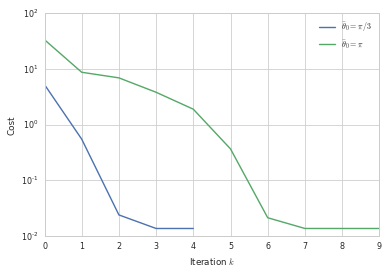

In [218]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summaries_noise[0]['iterations'])['cost'], label=r'$\bar{\theta}_0 = \pi / 3$')
ax.plot(pd.DataFrame(summaries_noise[1]['iterations'])['cost'], label=r'$\bar{\theta}_0 = \pi$')

# plt.axhline(y=summary_vd['iterations'][0]['cost'])

# ax.plot([it['cost'] for it in summary_point_1_res['iterations']])
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
plt.savefig('hetero-noise.pdf')

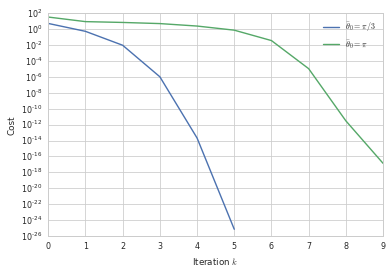

In [217]:
fig, ax = plt.subplots(1)

ax.plot(pd.DataFrame(summaries_no_noise[0]['iterations'])['cost'], label=r'$\bar{\theta}_0 = \pi / 3$')
ax.plot(pd.DataFrame(summaries_no_noise[1]['iterations'])['cost'], label=r'$\bar{\theta}_0 = \pi$')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
plt.savefig('hetero-nonoise.pdf')

## Noise

### 6 residuals

In [49]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b_noisy):
    mes.add_line_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_6_res_noise, summary_lines_6_res_noise, _) = mes.solve()
print(summary_lines_6_res['brief_report'])
print(em_lines_6_res_noise)

Ceres Solver Report: Iterations: 5, Initial cost: 1.883237e+01, Final cost: 1.086445e-23, Termination: CONVERGENCE
Mot: [ 0.88 -4.7e-14 -0.47 7.1e-14 -0.68 -0.44 -0.16 -0.23 ]


### 4 residuals

In [63]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b_noisy):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_4_res_noise, summary_lines_4_res_noise, _) = mes.solve()
print(summary_lines_4_res_noise['brief_report'])
print(em_lines_4_res_noise)

Ceres Solver Report: Iterations: 6, Initial cost: 6.561049e+00, Final cost: 2.340054e-17, Termination: CONVERGENCE
Mot: [ 0.88 -2.9e-09 -0.47 2.9e-09 -0.68 -0.44 -0.16 -0.23 ]


In [64]:
np.allclose(em_lines_6_res_noise, em_lines_4_res_noise)

True

### Valkenburg and Dorst

In [61]:
vd = VDMotorEstimationSolver()
vd.add_dual_line_observations(lines_a,lines_b_noisy)
vd_em_lines_noise = vd.solve()
print(vd_em_lines_noise)

Mot: [ -0.88 1.7e-17 0.47 3.2e-18 0 0 0 0 ]


In [62]:
vd = VDMotorEstimationSolver()
vd.add_dual_line_observations(lines_a,lines_b)
vd_em_lines = vd.solve()
print(vd_em_lines)

Mot: [ -0.87 3.1e-17 0.5 7.2e-18 0 0 0 0 ]


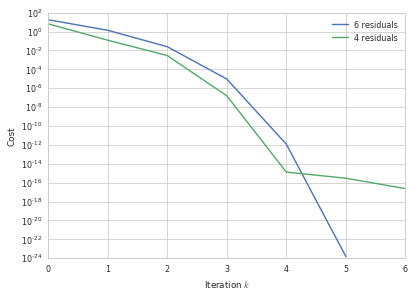

In [52]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_lines_6_res_noise['iterations'])['cost'], label=r'6 residuals')
ax.plot(pd.DataFrame(summary_lines_4_res_noise['iterations'])['cost'], label=r'4 residuals')
# plt.axhline(y=summary_vd['iterations'][0]['cost'])

# ax.plot([it['cost'] for it in summary_point_1_res['iterations']])
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
# plt.savefig('lines-noise.pdf')

# Visualization

In [68]:
scene = Scene(children=
#               [line_mesh(line,color=Colors.HOTPINK) for line in lines_a[:2]] +\
              [line_mesh(line,color=Colors.LIGHTSKYBLUE) for line in lines_b[:2]] +\
              [line_mesh(line,color='palegreen') for line in lines_b_noisy[:2]] +\
              
#               [line_mesh(line.spin(vd_em_lines),color=Colors.DEEPPINK) for line in lines_a[:2]] +\
              [line_mesh(line.spin(em_lines_6_res_noise), color=Colors.HOTPINK) for line in lines_a[:2]] +\
              [frame_mesh(),AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
renderer.width = '1024'
renderer.height = '768'
display(renderer)